In [33]:
import mlrun

In [34]:
project = mlrun.get_or_create_project(name="schedule-workflow", context="./")

> 2025-01-25 04:27:58,194 [info] Project loaded successfully: {"project_name":"schedule-workflow"}


In [35]:
project.set_source(source="git://github.com/xsqian/mlrun-github-example.git#main", pull_at_runtime=True)

In [36]:
# %%writefile src/func1.py
# def handler():
#     print("inside func1")
#     return "return from func1"

In [37]:
fn = project.set_function(
    name="function1",
    func="src/func1.py",
    kind="job",
    image="mlrun/mlrun",
    handler="handler",
    with_repo=True,
)

In [38]:
fn=project.get_function("function1")

In [39]:
fn.run(local=True)

> 2025-01-25 04:28:29,348 [info] Storing function: {"db":"http://mlrun-api:8080","name":"function1-handler","uid":"4368d401911a46bc9e7e73c039af7af2"}
inside func1


project,uid,iter,start,state,kind,name,labels,inputs,parameters,results
schedule-workflow,...39af7af2,0,Jan 25 04:28:29,completed,run,function1-handler,v3io_user=xingshengkind=localowner=xingshenghost=jupyter-xingsheng-5bb5c47b84-wwljv,,,return=return from func1


> 2025-01-25 04:28:29,641 [info] Run execution finished: {"name":"function1-handler","status":"completed"}


In [40]:
%%writefile src/schedule-workflow.py

from kfp import dsl
import mlrun


# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="scheduled-pipeline",
    description="Example of scheduled pipeline"
)
def pipeline():
    
    # Get current project
    project = mlrun.get_current_project()

    f1 = project.get_function("function1")

    # Ingest the data set
    f1_rs = project.run_function(
        function=f1
    )

    project.run_function(
        function=f1
    ).after(f1_rs)

Overwriting src/schedule-workflow.py


In [41]:
project.set_workflow(name="main", workflow_path="src/schedule-workflow.py")
project.save()

> 2025-01-25 04:29:28,231 [warning] WARNING!, You seem to have uncommitted git changes, use .push()
> 2025-01-25 04:29:28,233 [info] Submitting remote workflow: {"project_name":"schedule-workflow","schedule":null,"workflow_engine":"kfp"}


> 2025-01-25 04:29:32,644 [info] Started run workflow schedule-workflow-main with run id = '4d1745b6-00ba-46d7-9ad2-241ca2541406' by remote engine
> 2025-01-25 04:29:32,645 [info] Waiting for pipeline run completion: {"project":"schedule-workflow","run_id":"4d1745b6-00ba-46d7-9ad2-241ca2541406"}


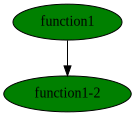

uid,start,state,kind,name,parameters,results
...20f83ba0,Jan 25 04:30:07,completed,run,function1,,return=return from func1
...4f0a3167,Jan 25 04:29:40,completed,run,function1,,return=return from func1


4d1745b6-00ba-46d7-9ad2-241ca2541406

In [43]:
project.run(name='main', watch=True, dirty=True, engine="remote")

In [56]:
%%writefile src/nucl.py
import mlrun
def handler(context, event):
    project = mlrun.get_or_create_project(name="schedule-workflow", context="./")
    # project.set_source(source="git://github.com/xsqian/mlrun-github-example.git#main", pull_at_runtime=True)
    workflow_instance = project.run(
                    name="main",
                    watch=False,
                    engine="remote"
                    )

Overwriting src/nucl.py


In [57]:
fn = project.set_function(
    name="nuc-a-workflow", 
    func="src/nucl.py", 
    kind="nuclio", 
    image="mlrun/mlrun", 
    # with_repo=True
)

fn.deploy()

> 2025-01-25 06:06:31,982 [info] Starting remote function deploy
2025-01-25 06:06:32  (info) Deploying function
2025-01-25 06:06:32  (info) Building
2025-01-25 06:06:32  (info) Staging files and preparing base images
2025-01-25 06:06:32  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-01-25 06:06:32  (info) Building processor image
2025-01-25 06:09:18  (info) Build complete
2025-01-25 06:09:26  (info) Function deploy complete
> 2025-01-25 06:09:34,103 [info] Successfully deployed function: {"external_invocation_urls":["schedule-workflow-nuc-a-workflow.default-tenant.app.cst-360.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-schedule-workflow-nuc-a-workflow.default-tenant.svc.cluster.local:8080"]}


'http://schedule-workflow-nuc-a-workflow.default-tenant.app.cst-360.iguazio-cd0.com/'